This is the exact solution of the adviction equation in 1D with 1 wave going from left to right at a constant speed.

In [1]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from IPython.display import display, clear_output # this is for plotting animations
import sys
init_printing()

The equation we are trying to model is the advection equation:

$$q_x + \hat{u}q_t = 0$$

making of the initial data

In [2]:
# 0 = FDM, 1 = FVM
mode_FVM = 1
#scheme: 0 = upwind_method, 1=unstable_flux, 2=Lax-Wendroff
scheme = 0
# write 0 below for discontinuous wave, 1 for gaussian wave and 2 for dambreak wave
current_wave = 1 
# we have x on an interval [0,2], t = [0,1] and we timestep each in 1001 steps, which gives us 1000 intervals
if (mode_FVM == 0):
    Nx_points = 101
else:
    Nx_points = 1001
min_x = 0 
max_x = 1
length_x = max_x - min_x
Nx_intervals = Nx_points-1
dx_points = 1/Nx_intervals
dt = 0.01
t_end = 0.3
Nt = int(t_end/dt)
t = np.linspace(0,t_end,Nt+1)
Ax_points = np.linspace(0,length_x,Nx_points)
N_integrals = 0 # will never be 0, just need to initialize it here for scope purposes 
N_plots_shown = 80 
if (Nx_intervals%10 != 0):
    print("x_points is not a multiple of 10, this will cause problems in the integral")
    sys.exit()
else:
    N_integrals = Nx_intervals//10
N_p_pr_integral = Nx_intervals/N_integrals # number of points in each intergral of the FVM method 
dx_integrals = length_x/N_integrals
Ax_integrals = np.linspace(0,length_x,N_integrals)
u_hat = 0.8 # this is the speed of the single wave 
CFL_points = u_hat*dt/dx_points
CFL_integrals = u_hat*dt/dx_integrals
print("CFL for points: " + str(CFL_points))
print("CFL for integrals: " + str(CFL_integrals))

CFL for points: 8.0
CFL for integrals: 0.8


Generating 3 initial waves. 
1. Discountinues from a saw wave.
2. Gaussian curve with $\sigma = 0.07$ and $\mu = 0.5$
3. Dambreak at x=0.5 with the value 5 on the lhs and 0 on the rhs

In [3]:
def generate_initial_waves(Nx_points_l, Ax_points_l): # l for the local values
    # defining initial-condition for a discontinuous wave
    initial_dis_wave = np.zeros(Nx_points_l) 
    for i in range(0,Nx_points_l//3):
        initial_dis_wave[int(Nx_points_l/4)+i] = i*(25/Nx_points_l)
    # defining initial for a gaussian wave 
    sigma = 0.07 
    mu = 0.5 
    initial_gaus_wave =1/(sigma*np.sqrt(2))*np.exp(-0.5*((Ax_points_l-mu)/sigma)**2) 

    higher_dam_break_v = 5.0
    # defining initial for a dambreak wave 
    initial_dam_break = np.zeros(Nx_points_l)
    for i in range(0,int(Nx_points_l//2)):
        initial_dam_break[i] = higher_dam_break_v 
    return initial_dis_wave, initial_gaus_wave, initial_dam_break

In [4]:
waves = generate_initial_waves(Nx_points, Ax_points) 

Making a plot of the initial waves:

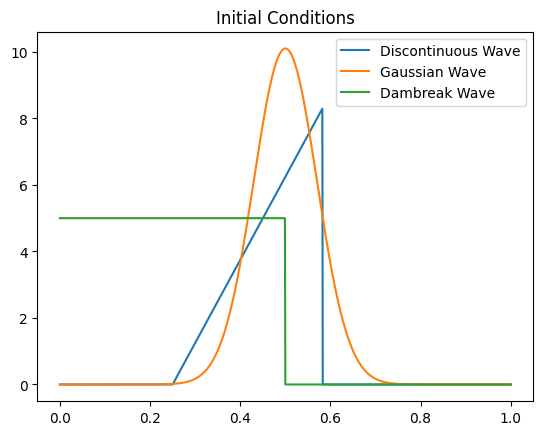

In [5]:
#plot initial waves and make sure CFL condition is satisfied
plt.plot(Ax_points,waves[0], label = 'Discontinuous Wave')
plt.plot(Ax_points,waves[1], label = 'Gaussian Wave')
plt.plot(Ax_points,waves[2], label = 'Dambreak Wave')
plt.title('Initial Conditions')
plt.legend()

Here is a pointwise upwind method applied:

$$u_i^{n+1}=u_i^n-\frac{\hat{u}\Delta t}{\Delta x}(u_i^n-u_{i-1}^n)$$

In [6]:
def exact_wave(initial_values, x, dx, n, dt, u, interval_size):
    # defining the exact solution for a single wave with transitive boundary conditions
    d = u_hat*(n+1)*dt
    while (d > interval_size):
        d = d - interval_size 
    x_on_original = np.mod(x - d,interval_size)
    index = int(x_on_original/dx)  
    return initial_values[index]

In [7]:
def plot_scheme(fig, ax, x, data, exact_solution, CFL, dt, n, wave_type):
    ax.cla()
    ax.plot(x,exact_solution, color = 'blue')
    ax.scatter(x,data, marker='o', facecolors='white', color='k', s=1)
    fig.gca().legend(('Exact solution','Upwind scheme pointwise (CFL='+str(CFL)+')'))
    ax.set_xlabel('x')
    ax.set_ylabel('value')
    match wave_type:
        case 0: # This is the discontinuous wave
            fig.suptitle('Saw wave t='+str(round(dt*(n+1),3)),fontsize=13)
        case 1: # This is the gaussian wave
            fig.suptitle('Gaussian wave t='+str(round(dt*(n+1),3)),fontsize=13)
        case 2: # This is the dambreak wave
            fig.suptitle('Dambreak wave t='+str(round(dt*(n+1),3)),fontsize=13)
    display(fig)
    clear_output(wait=True)
    plt.pause(0.001)

In [8]:
def Upwind_scheme(initial_values, CFL, dt, Nt, dx, Nx, Ax, current_wave, plotting, interval_size):
    u_next = np.zeros(Nx+1)          
    u_current = np.zeros(Nx+1)          ## we make a ghost cell at the start of the grid, that copies the last cell 
    u_current[1:Nx+1] = np.copy(initial_values)
    u_current[0] = u_current[Nx]
    u_exact = np.copy(initial_values)
   
    for n in range (0,Nt):
        for i in range (1,Nx+1):
            u_next[i] = u_current[i] - CFL*(u_current[i]-u_current[i-1])
            if i == Nx:
                break
            u_exact[i] = exact_wave(initial_values, Ax[i], dx, n, dt, u_hat, interval_size)  
        # we make a transitive boundary condition, where the last point is equal to the first point
        u_next[0] = u_next[Nx]
        u_exact[0] = exact_wave(initial_values, Ax[0], dx, n, dt, u_hat, interval_size)  
        u_current = np.copy(u_next)
        
        if (plotting and n==0): fig, ax = plt.subplots(figsize=(5,4))
        if (plotting and n%(Nt//N_plots_shown)==0): plot_scheme(fig, ax, Ax, u_current[1:], u_exact, CFL, dt, n, current_wave)

    # The error can be calculated as pr. page 252(A.17) with the 2 norm in the book Randall Leveque - Finite Difference Methods for Ordinary and Partial Differential Equations
    array_diff = u_exact - u_current[1:]
    error =np.sqrt(dx * np.linalg.norm(array_diff**2,1))
    plt.show()
    return error

In [9]:
if mode_FVM == 0:
    error = Upwind_scheme(waves[current_wave], CFL_points, dt, Nt, dx_points, Nx_points, Ax_points, current_wave, True, max_x)
    print("Error for the pointwise scheme: " + str(error))

Lets try and solve the same problem with a numerical solution using the FVM.
$$ Q_i^{n+1}=Q_i^n-\frac{\hat{u}\Delta t}{\Delta x}(Q_{i}^n-Q_{i-1}^n)$$

We start by setting the grid into intervals.

In [10]:
# interval has to be a multiple of interval_q 
def compute_Q0(Np_pr_integral, N_integrals, wave):
    Q_0_l = [] # l for local
    for i in range(0,N_integrals):
        Q_current = 0
        for j in range(0,Np_pr_integral):
            Q_current = Q_current + wave[i*Np_pr_integral+j]
        Q_0_l.append(Q_current/Np_pr_integral)
    return Q_0_l

In [11]:
Q_0 = []
if N_p_pr_integral.is_integer():
    N_p_pr_integral = int(N_p_pr_integral)
else:
    print('Error: Number of points for each integral is not an integer')
    sys.exit(1)
if mode_FVM == 1:
    Q_0 = compute_Q0(N_p_pr_integral, N_integrals, waves[current_wave])

We do the upwind method for the advection equation, this is based on 4.25 Leveque (Finite Volume):

In [12]:
if mode_FVM == 1 and scheme == 0:
    error_upwind_FVM = Upwind_scheme(Q_0, CFL_integrals, dt, Nt, dx_integrals, N_integrals, Ax_integrals, current_wave, False, max_x)
    print('The error for the Upwind scheme is: ', error_upwind_FVM)

The error for the Upwind scheme is:  0.1421196483238864


Trying to use the scheme which is unstable:

$$Q_i^{n+1} = Q_i^n - \frac{\hat{u}\Delta t}{2\Delta x}(Q_{i+1}^n-Q_{i-1}^n)$$

In [13]:
def Unstable_flux_scheme(initial_values, CFL, dt, Nt, dx, Nx, Ax, current_wave, plotting, interval_size):
    u_next = np.zeros(Nx+1)          
    u_current = np.zeros(Nx+1)          ## we make a ghost cell at the start 
    u_current[1:Nx+1] = np.copy(initial_values)
    u_current[0] = u_current[Nx]
    u_exact = np.copy(initial_values)
   
    for n in range (0,Nt):
        for i in range (1,Nx):
            u_next[i] = u_current[i] - CFL/2*(u_current[i+1]-u_current[i-1])
            u_exact[i] = exact_wave(initial_values, Ax[i], dx, n, dt, u_hat, interval_size)  
        # we make a transitive boundary condition, where the last point is equal to the first point
        u_next[Nx] = u_current[Nx] - CFL/2*(u_current[0]-u_current[Nx-1])
        u_next[0] = u_next[Nx]
        u_exact[0] = exact_wave(initial_values, Ax[0], dx, n, dt, u_hat, interval_size)  
        u_current = np.copy(u_next)
        
        if (plotting and n==0): fig, ax = plt.subplots(figsize=(5,4))
        if (plotting and n%(Nt//N_plots_shown)==0): plot_scheme(fig, ax, Ax, u_current[1:], u_exact, CFL, dt, n, current_wave)

    # The error can be calculated as pr. page 252(A.17) with the 2 norm in the book Randall Leveque - Finite Difference Methods for Ordinary and Partial Differential Equations
    array_diff = u_exact - u_current[1:]
    error =np.sqrt(dx * np.linalg.norm(array_diff**2,1))
    plt.show()
    return error

In [14]:
if mode_FVM == 1 and scheme == 1: #this is an unstable scheme and should produce bad results.
    error_Unstable_flux_scheme = Unstable_flux_scheme(Q_0, CFL_integrals, dt, Nt, dx_integrals, N_integrals, Ax_integrals, current_wave, True, max_x)

We evalute a second order scheme which is the Lax-Wendroff Method, given by:

$$Q_i^{n+1}=Q_i^n-\frac{\hat{u}\Delta t}{2\Delta x}(Q_{i+1}^n-Q_{i-1}^n)+\frac{1}{2}(\frac{\Delta t\hat{u}}{\Delta x})^2(Q_{i+1}^n-2Q_i^n+Q_{i-1}^n)$$

In [15]:
def Lax_Wendroff_scheme(initial_values, CFL, dt, Nt, dx, Nx, Ax, current_wave, plotting, interval_size):
    u_next = np.zeros(Nx+1)          
    u_current = np.zeros(Nx+1)          ## we make a ghost cell at the start 
    u_current[1:Nx+1] = np.copy(initial_values)
    u_current[0] = u_current[Nx]
    u_exact = np.copy(initial_values)
   
    for n in range (0,Nt):
        for i in range (1,Nx):
            u_next[i] = u_current[i] - CFL/2*(u_current[i+1]-u_current[i-1])+1/2*CFL**2*(u_current[i+1]-2*u_current[i]+u_current[i-1])
            u_exact[i] = exact_wave(initial_values, Ax[i], dx, n, dt, u_hat, interval_size)  
        # we make a transitive boundary condition, where the last point is equal to the first point
        u_next[Nx] = u_current[Nx] - CFL/2*(u_current[0]-u_current[Nx-1])+1/2*CFL**2*(u_current[0]-2*u_current[Nx]+u_current[Nx-1])
        u_next[0] = u_next[Nx]
        u_exact[0] = exact_wave(initial_values, Ax[0], dx, n, dt, u_hat, interval_size)  
        u_current = np.copy(u_next)
        
        if (plotting and n==0): fig, ax = plt.subplots(figsize=(5,4))
        if (plotting and n%(Nt//N_plots_shown)==0): plot_scheme(fig, ax, Ax, u_current[1:], u_exact, CFL, dt, n, current_wave)

    # The error can be calculated as pr. page 252(A.18) with the 2 norm in the book Randall Leveque - Finite Difference Methods for Ordinary and Partial Differential Equations
    array_diff = u_exact - u_current[1:]
    error =np.sqrt(dx * np.sum(np.abs(array_diff)**2)) # 2 norm
    plt.show()
    return error

In [16]:
if mode_FVM == 1 and scheme == 2: #this is a second order method 
    error_Lax_Wendroff_scheme = Lax_Wendroff_scheme(Q_0, CFL_integrals, dt, Nt, dx_integrals, N_integrals, Ax_integrals, current_wave, true, max_x)
    print('The error for the Lax-Wendroff scheme is: ', error_Lax_Wendroff_scheme)

Error plotting to show first order and second order, we plot the upwind scheme and Lax Wendroff, where CFL is held constant to 0.8:

Text(0.5, 1.0, 'Order of accuracy of 2 schemes')

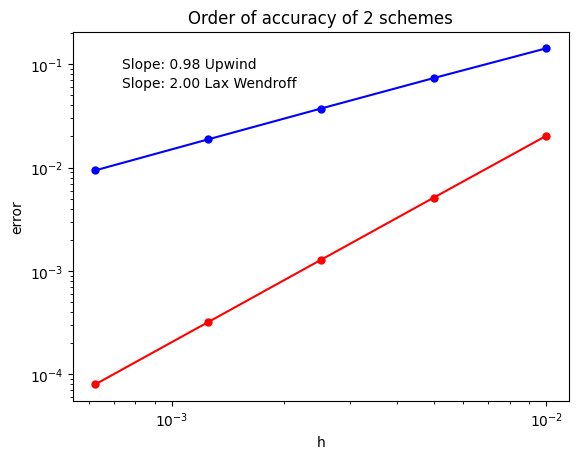

In [17]:
# This cell takes about 2 min to run, depending on the hardware.
error_Lax = []
error_Upwind = []
h = []
for i in range(0,5):
    error_Lax.append(Lax_Wendroff_scheme(Q_0, CFL_integrals, dt, Nt, dx_integrals, N_integrals, Ax_integrals, current_wave, False, max_x))
    error_Upwind.append(Upwind_scheme(Q_0, CFL_integrals, dt, Nt, dx_integrals, N_integrals, Ax_integrals, current_wave, False, max_x))
    h.append(dx_integrals)
    # half the time step and double the number of points, CFL is constant. 
    dt = dt/2
    dx_integrals = dx_integrals/2
    N_integrals = N_integrals*2
    Nx_intervals = Nx_intervals*2
    Nx_points = Nx_intervals+1
    Ax_points = np.linspace(0, max_x, Nx_points)
    Ax_integrals = np.linspace(0, max_x, N_integrals)
    Nt = int(t_end/dt)
    waves = generate_initial_waves(Nx_points, Ax_points)
    Q_0 = compute_Q0(N_p_pr_integral, N_integrals, waves[current_wave])
# plotting

fig, ax = plt.subplots()

# plot the data points
ax.loglog(h, error_Lax, 'o', markersize=5, color='red')
ax.loglog(h, error_Upwind, 'o', markersize=5, color='blue')
# plot a line between the data points
ax.loglog(h, error_Lax, '-', markersize=5, color='red')
ax.loglog(h, error_Upwind, '-', markersize=5, color='blue')
# calculate the slope of the line using NumPy's polyfit function
m_Lax, b_Lax = np.polyfit(np.log(h), np.log(error_Lax), 1)
m_Upwind, b_Upwind = np.polyfit(np.log(h), np.log(error_Upwind), 1)

# add the slope to the plot
ax.text(0.1, 0.85, f"Slope: {m_Lax:.2f} Lax Wendroff", transform=ax.transAxes)
ax.text(0.1, 0.90, f"Slope: {m_Upwind:.2f} Upwind", transform=ax.transAxes)

# set the x and y axis labels and title
ax.set_xlabel('h')
ax.set_ylabel('error')
ax.set_title('Order of accuracy of 2 schemes')